In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import heapq
import random
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk

In [3]:
def parse_txt(file_path):
    graphs = []  
    current_matrix = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            if line.startswith("Graph"):
                if current_matrix:
                    adj_matrix = np.array(current_matrix, dtype=int)
                    G = nx.from_numpy_array(adj_matrix)
                    for u, v in G.edges():
                        G[u][v]['weight'] = random.randint(1, 10) 
                    graphs.append(G)
                    current_matrix = [] 
            
            elif line:  
                    current_matrix.append([int(char) for char in line])
            
        if current_matrix:
            adj_matrix = np.array(current_matrix, dtype=int)
            G = nx.from_numpy_array(adj_matrix)
            for u, v in G.edges():
                G[u][v]['weight'] = random.randint(1, 10)
            graphs.append(G)
            
        return graphs

In [4]:
def visualize_all_graphs(graphs):
    i = 1  
    for graph in graphs:
        plt.figure(figsize=(6, 6))
        
        pos = nx.spring_layout(graph, seed=42) 
        
        nx.draw(graph, pos, with_labels=True, node_color='pink', edge_color='gray')
        
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        
        plt.title(f"Graph {i}")
        
        plt.show()
        i += 1
        



In [5]:
def prim_mst(G):
    
    start_node = list(G.nodes())[0]  
    visited = set([start_node])
    
    edges = [
        (G[start_node][dest]["weight"], start_node, dest)
        for dest in G[start_node]
    ]
    heapq.heapify(edges)  
    mst = []
    steps = [] 
    
    while edges and len(visited) < len(G.nodes):
        weight, src, dest = heapq.heappop(edges)
        if dest in visited:
            continue
        visited.add(dest)
        mst.append((weight, src, dest))
        steps.append(list(mst))
        
        
        for neighbor, edge_attr in G[dest].items():
            if neighbor not in visited:
                edge_weight = edge_attr["weight"]
                heapq.heappush(edges, (edge_weight, dest, neighbor))
    
    return mst, steps


In [6]:
def kruskal_mst(G):
    
    edges = [
        (G[u][v]["weight"], u, v) for u, v in G.edges()
    ]
    heapq.heapify(edges)
    mst = []
    steps = []

    parent = {node: node for node in G.nodes()}
    rank = {node: 0 for node in G.nodes()}
    
    def find(node):

        if parent[node] != node:
            parent[node] = find(parent[node])
        return parent[node]
    
    def union(node1, node2):
        root1, root2 = find(node1), find(node2)
        if root1 != root2:
            if rank[root1] > rank[root2]:
                parent[root2] = root1
            elif rank[root1] < rank[root2]:
                parent[root1] = root2
            else:
                parent[root2] = root1
                rank[root1] += 1
    
 
    while edges and len(mst) < len(G.nodes()) - 1:
        weight, u, v = heapq.heappop(edges)
        if find(u) != find(v): 
            union(u, v)
            mst.append((weight, u, v))
            steps.append(list(mst)) 
    
    return mst, steps

In [7]:
graphs = parse_txt("graph_output.txt")

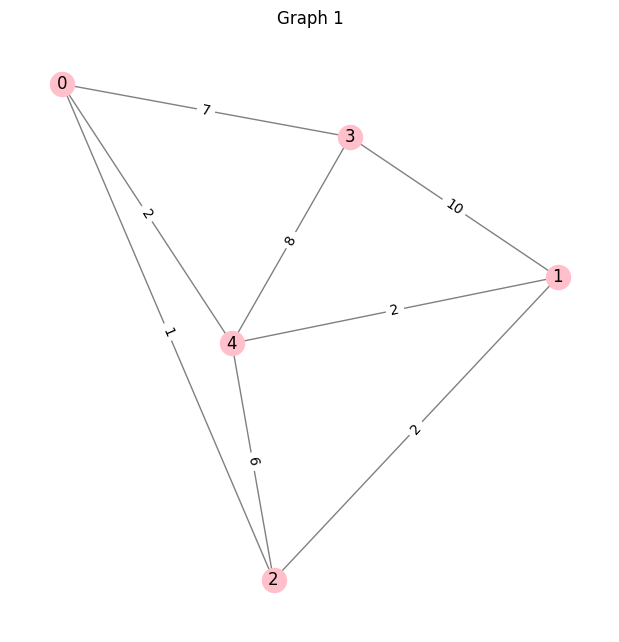

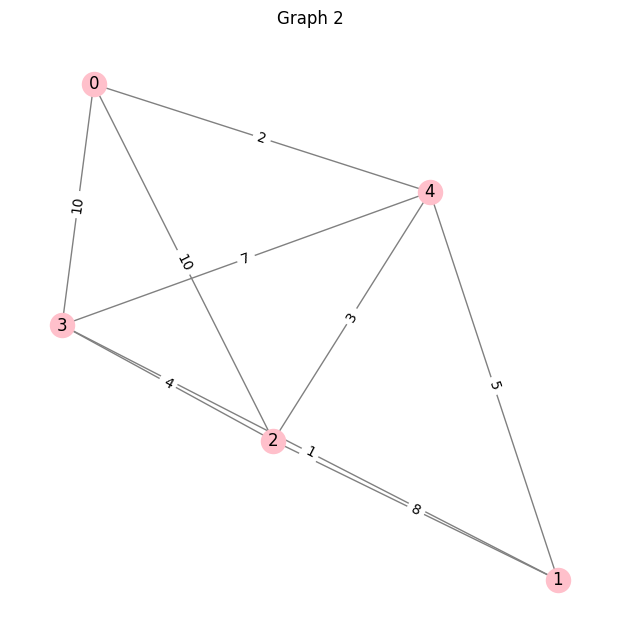

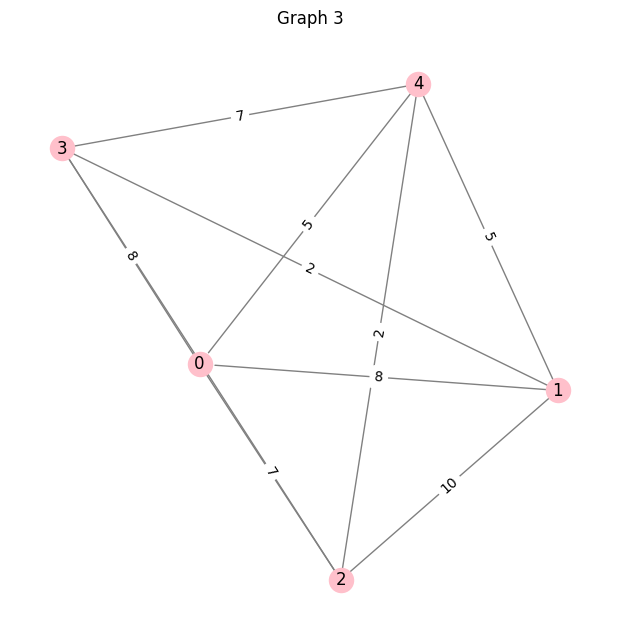

In [8]:
visualize_all_graphs(graphs)

In [9]:
# i = 1  
# for graph in graphs:
#     mst_edges = prim_mst(graph)
#     print(f"MST for Graph {i}:", mst_edges)
#     i += 1  


In [10]:
def update_graph(graph, steps, step_index, canvas, ax):
    ax.clear()  

    pos = nx.spring_layout(graph, seed=42)  
    edge_labels = nx.get_edge_attributes(graph, 'weight')  

   
    visited_nodes = set()
    mst_edges = []

    
    if step_index > 0:  
        current_edges = steps[step_index - 1]
        for edge in current_edges:
            weight, src, dest = edge
            visited_nodes.add(src)  
            visited_nodes.add(dest)
            mst_edges.append((src, dest))  

    
    node_colors = ['red' if node in visited_nodes else 'pink' for node in graph.nodes()]

   
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, edge_color='gray', ax=ax)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax)

    
    if mst_edges:
        nx.draw_networkx_edges(graph, pos, edgelist=mst_edges, edge_color='red', width=2, ax=ax)
        
    if step_index == 0:  
        diameter = calculate_diameter(graph)
        ax.set_title( f"Diameter of Original Graph = {diameter}")


    
    canvas.draw()

In [11]:
def calculate_diameter(graph, mst_edges=None):
    if mst_edges:
        
        mst_graph = nx.Graph()
        for weight, src, dest in mst_edges:
            mst_graph.add_edge(src, dest, weight=weight)
       
        return nx.diameter(mst_graph, weight='weight')
    else:
       
        return nx.diameter(graph, weight='weight')


In [12]:
def plot_graph_gui(graph):
    current_graph_index = [0]  
    mst = None
    steps = None
    current_step_index = [0]  
    
    window = tk.Tk()
    window.title("MST Visualization")
    
    def load_graph(index):
        nonlocal mst, steps, current_step_index
        current_step_index[0] = 0
        current_graph_index[0] = index
        graph = graphs[index]
        mst, steps = prim_mst(graph)
        update_graph(graph, steps, current_step_index[0], canvas, ax)
        status_label.config(text="")  
        graph_diameter_label.config(text="")
        mst_diameter_label.config(text="")
        
    def next_step():
        if current_step_index[0] < len(steps):
            current_step_index[0] += 1
            update_graph(graphs[current_graph_index[0]], steps, current_step_index[0], canvas, ax)

            if current_step_index[0] == len(steps):
                canvas.draw()
                status_label.config(text="The full MST has been determined!")
                
                graph_diameter = calculate_diameter(graph)
                mst_diameter = calculate_diameter(graph, mst_edges=steps[-1])
            
                graph_diameter_label.config(text=f"Graph Diameter: {graph_diameter}")
                mst_diameter_label.config(text=f"MST Diameter: {mst_diameter}")
                
                
    def prev_step():
        if current_step_index[0] > 0:
            current_step_index[0] -= 1
            update_graph(graphs[current_graph_index[0]], steps, current_step_index[0], canvas, ax)
            status_label.config(text="")
            graph_diameter_label.config(text="")
            mst_diameter_label.config(text="")
            
            
    def on_graph_select(val):
        load_graph(graph_options.index(val))
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    
    graph_options = [f"Graph {i+1}" for i in range(len(graphs))]
    selected_graph = tk.StringVar(window)
    selected_graph.set(graph_options[0])  
    
    
    dropdown = tk.OptionMenu(window, selected_graph, *graph_options, command=on_graph_select)
    dropdown.pack(pady=10)

    
    status_label = tk.Label(window, text="", font=("Arial", 24), fg="red")
    status_label.pack(pady=10)

    graph_diameter_label = tk.Label(window, text="", font=("Arial", 14), fg="red")
    graph_diameter_label.pack(pady=5)

    mst_diameter_label = tk.Label(window, text="", font=("Arial", 14), fg="red")
    mst_diameter_label.pack(pady=5)
     
    button_frame = tk.Frame(window)
    button_frame.pack(fill=tk.X, side=tk.BOTTOM, pady=20)
    
    prev_button = tk.Button(button_frame, text="Prev", command=prev_step)
    prev_button.pack(side=tk.LEFT, padx=150)

    next_button = tk.Button(button_frame, text="Next", command=next_step)
    next_button.pack(side=tk.RIGHT, padx=150)
    
    load_graph(0) 
    window.mainloop()
    

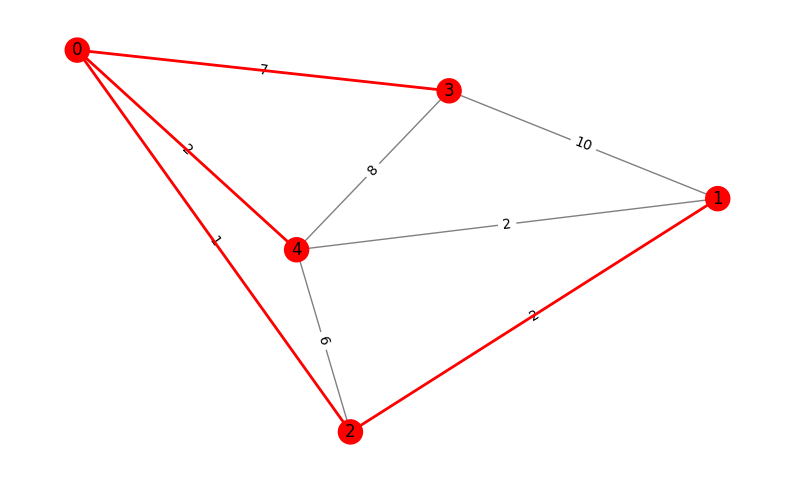

In [17]:
plot_graph_gui(graphs[0])

In [124]:
# i=0
# while (i<3):
#     dia = nx.diameter(graphs[i])
#     print("Diameter of graph #",i+1,":",dia)
#     i += 1


# j=0
# while (j<3):
#     mst1, _ = prim_mst(graphs[j])
#     mst_graph = nx.Graph()
#     mst_graph.add_edges_from([(edge[1], edge[2]) for edge in mst1])
#     mstdia = nx.diameter(mst_graph)
#     print("Diameter of mst #",j+1,":",mstdia)
#     j += 1

Diameter of graph # 1 : 2
Diameter of graph # 2 : 2
Diameter of graph # 3 : 1
Diameter of mst # 1 : 3
Diameter of mst # 2 : 4
Diameter of mst # 3 : 4
